In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

MAE: 28.548355620287786, RMSE: 37.78440766241706, R²: 0.5420555791608781


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


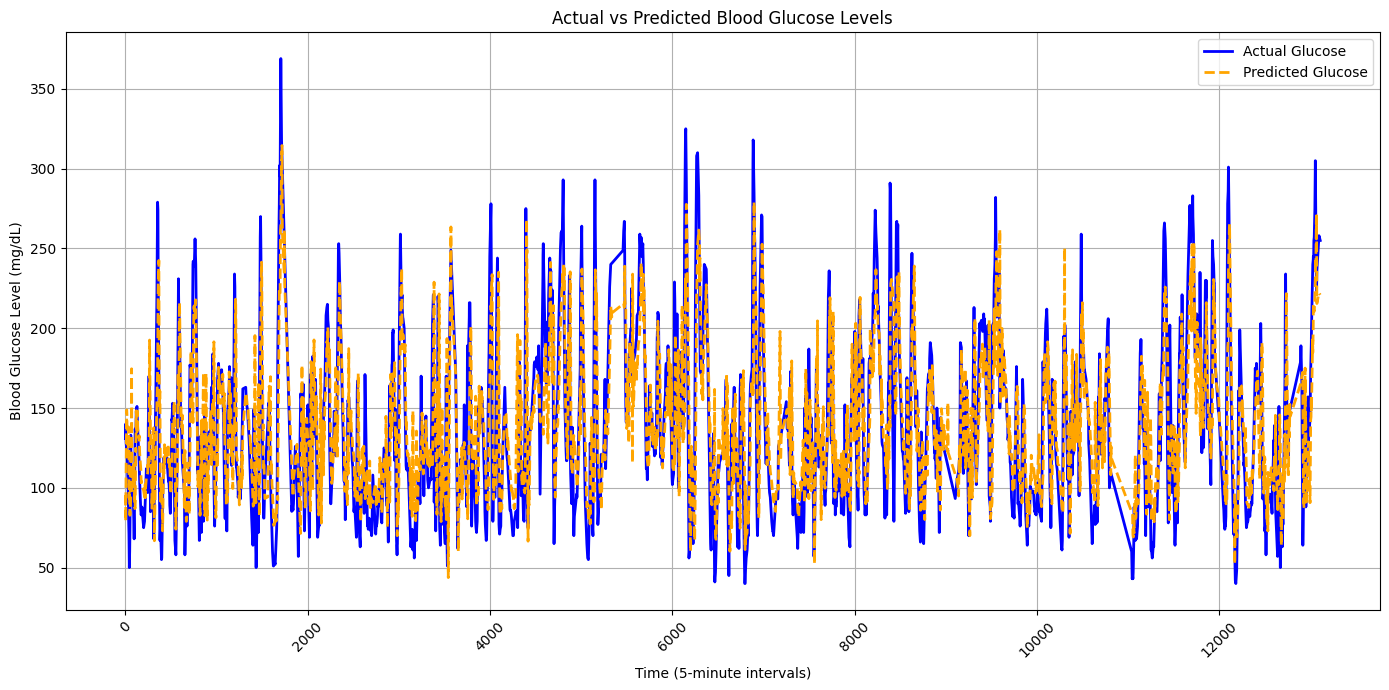

In [122]:
df = pd.read_csv("../../data/Ohio2020_processed/train/540-ws-training_processed.csv")

new_time = (np.linspace(0, 13108, 13109)).astype(int)
df['5minute_intervals_timestamp'] = new_time

# This line fills in the Nan with 0
df[['carbInput', 'bolus', 'basal']] = df[['carbInput', 'bolus', 'basal']].fillna(0)
# This line interpolates data when the cbg data is missing
df['cbg'] = df['cbg'].interpolate(method='linear')

# Create lagged features for glucose
lagged_features = {f'glucose_lag_{lag}': df['cbg'].shift(lag).bfill() for lag in range(1, 8)}
df = df.assign(**lagged_features)

prediction_horizon = 12  # this value times 5 gives you the time in min
df['target'] = df['cbg'].shift(-prediction_horizon)
df['target'] = df['target'].ffill()

X = df[['basal', 'bolus', 'carbInput', 'glucose_lag_1', 'glucose_lag_2', 'glucose_lag_3', 'glucose_lag_4']]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}, RMSE: {rmse}, R²: {r2}')

X_test_with_timestamp = X_test.copy()
X_test_with_timestamp['Timestamp'] = df.loc[X_test.index, '5minute_intervals_timestamp']

results = pd.DataFrame({
    'Timestamp': X_test_with_timestamp['Timestamp'],
    'Actual Glucose': y_test,
    'Predicted Glucose': y_pred
})

# Sort results by timestamp to ensure proper plotting
results = results.sort_values('Timestamp')

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(results['Timestamp'], results['Actual Glucose'], label='Actual Glucose', color='blue', linewidth=2)
plt.plot(results['Timestamp'], results['Predicted Glucose'], label='Predicted Glucose', color='orange', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted Blood Glucose Levels')
plt.xlabel('Time (5-minute intervals)')
plt.ylabel('Blood Glucose Level (mg/dL)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Average MAE: 28.90583597424419
Average RMSE: 37.439723403436716
Average R²: 0.5094388677229524


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_reg

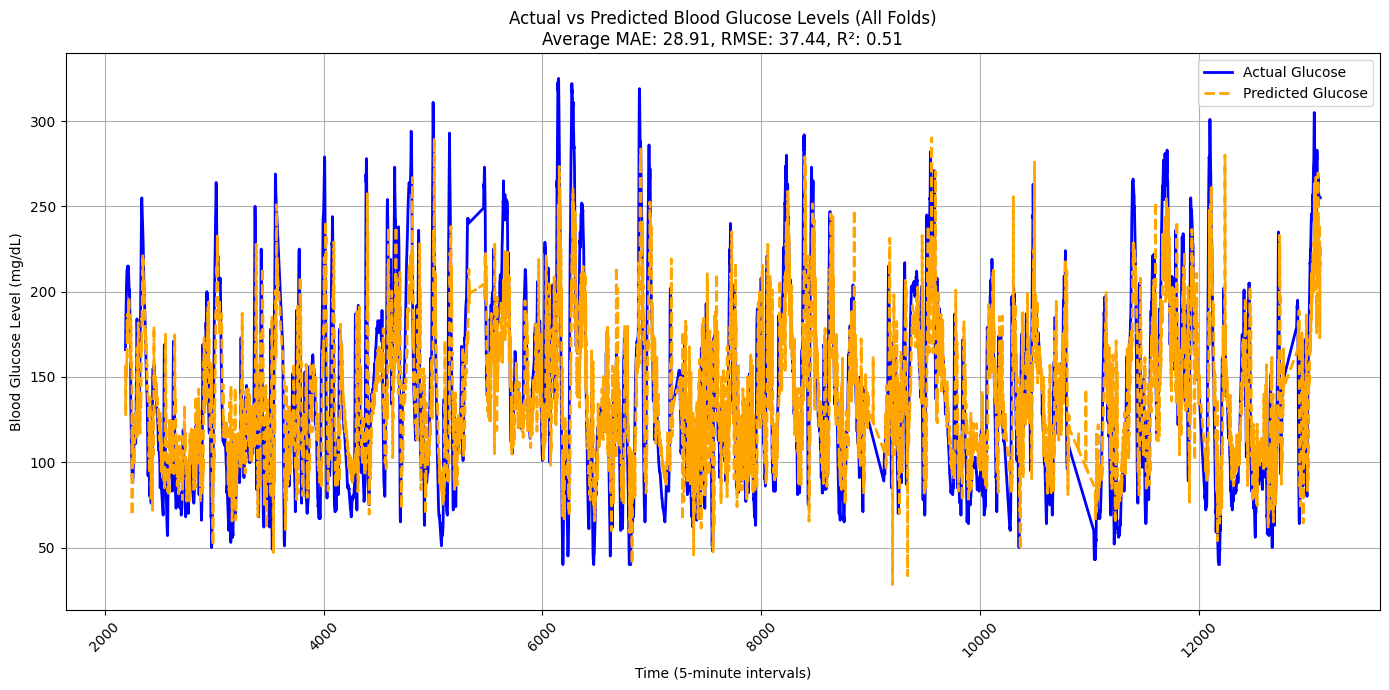

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = pd.read_csv("../../data/Ohio2020_processed/train/540-ws-training_processed.csv")

new_time = (np.linspace(0, 13108, 13109)).astype(int)
df['5minute_intervals_timestamp'] = new_time

# Fill NaN values with 0 for these columns
df[['carbInput', 'bolus', 'basal']] = df[['carbInput', 'bolus', 'basal']].fillna(0)

# Linear interpolation for missing CBG data
df['cbg'] = df['cbg'].interpolate(method='linear')

# Create lagged features for glucose
lagged_features = {f'glucose_lag_{lag}': df['cbg'].shift(lag).bfill() for lag in range(1, 8)}
df = df.assign(**lagged_features)

# Prediction target: 12 steps ahead (60 minutes)
prediction_horizon = 12
df['target'] = df['cbg'].shift(-prediction_horizon)
df['target'] = df['target'].ffill()

# Features and target
X = df[['basal', 'bolus', 'carbInput', 'glucose_lag_1', 'glucose_lag_2', 'glucose_lag_3', 'glucose_lag_4']]
y = df['target']

# Initialize the StandardScaler for normalization
scaler = StandardScaler()

# Time-based splitting using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize lists to accumulate results across all folds
all_timestamps = []
all_actuals = []
all_predictions = []

# Create arrays to store metrics across folds
mae_scores = []
rmse_scores = []
r2_scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Normalize the training and test data using StandardScaler
    X_train_scaled = scaler.fit_transform(X_train)  # Fit only on the training data
    X_test_scaled = scaler.transform(X_test)  # Transform the test data using the same scaler
    
    # Train the linear regression model on the scaled data
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Store timestamps, actual, and predicted values
    all_timestamps.extend(df.loc[X_test.index, '5minute_intervals_timestamp'])
    all_actuals.extend(y_test)
    all_predictions.extend(y_pred)
    
    # Calculate metrics for each fold
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    
    # Append metrics for this fold
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

# Calculate average metrics across all folds
average_mae = np.mean(mae_scores)
average_rmse = np.mean(rmse_scores)
average_r2 = np.mean(r2_scores)

# Print average performance across all folds
print(f'Average MAE: {average_mae}')
print(f'Average RMSE: {average_rmse}')
print(f'Average R²: {average_r2}')

# Create a DataFrame for the results across all folds
results = pd.DataFrame({
    'Timestamp': all_timestamps,
    'Actual Glucose': all_actuals,
    'Predicted Glucose': all_predictions
})

# Sort the results by Timestamp
results = results.sort_values('Timestamp')

# Plotting the actual vs predicted glucose levels across all folds (without range limit)
plt.figure(figsize=(14, 7))
plt.plot(results['Timestamp'], results['Actual Glucose'], label='Actual Glucose', color='blue', linewidth=2)
plt.plot(results['Timestamp'], results['Predicted Glucose'], label='Predicted Glucose', color='orange', linestyle='--', linewidth=2)
plt.title(f'Actual vs Predicted Blood Glucose Levels (All Folds)\nAverage MAE: {average_mae:.2f}, RMSE: {average_rmse:.2f}, R²: {average_r2:.2f}')
plt.xlabel('Time (5-minute intervals)')
plt.ylabel('Blood Glucose Level (mg/dL)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
